In [ ]:
#Gradcam
from keras.models import load_model as load_keras_model
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
# Load model
model_filename = ('D:/data/models/algorithm5_6_1.h5')
model = load_keras_model(model_filename)  
#print(model.summary())

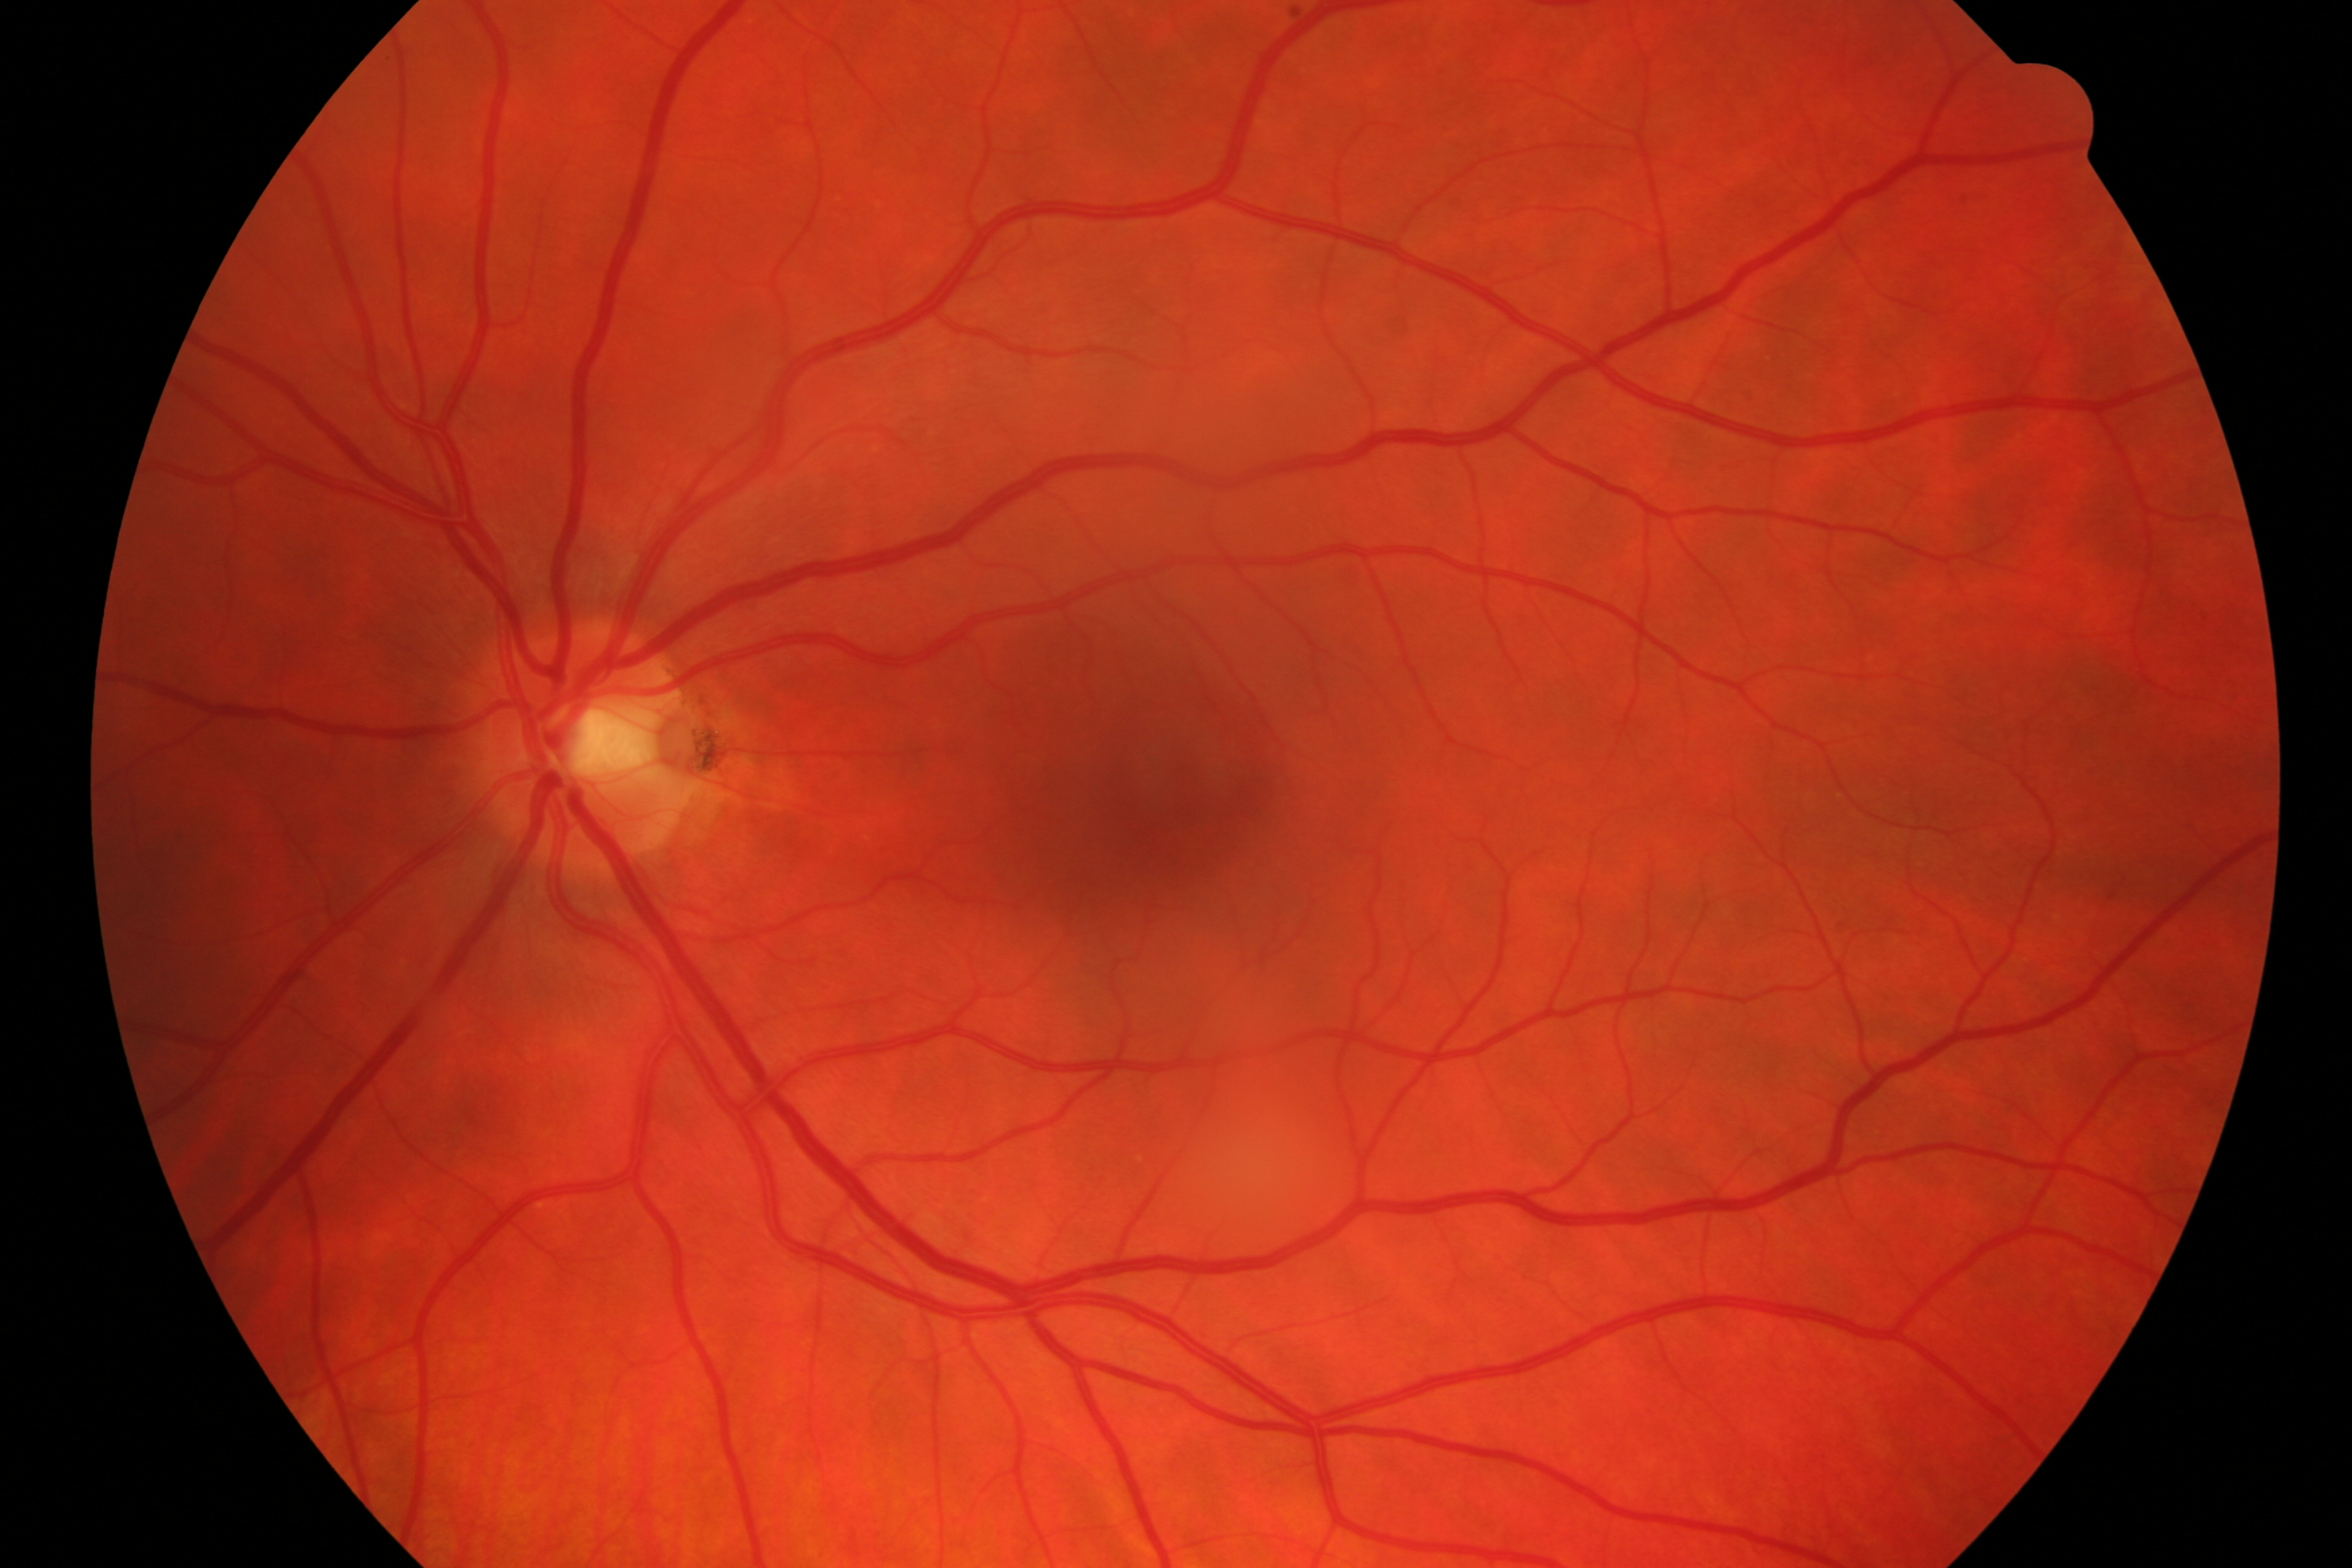

In [ ]:
preprocess_input = keras.applications.inception_v3.preprocess_input
decode_predictions = keras.applications.inception_v3.decode_predictions
last_conv_layer_name = "block14_sepconv2_act" 

img_size = (299, 299)

#Set a Target Image
img_path=('D:/data/full/02_g.jpg')
display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0) #expand the dimension
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.input],[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    p_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    hmap = last_conv_layer_output @ p_grads[..., tf.newaxis] 
    hmap = tf.squeeze(hmap)

    hmap = tf.maximum(hmap, 0) / tf.math.reduce_max(hmap) #normalize
    return hmap.numpy()

def save_and_display_gradcam(img_path, hmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    hmap = np.uint8(255 * hmap)
    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_hmap = jet_colors[hmap]
    jet_hmap = keras.preprocessing.image.array_to_img(jet_hmap)
    jet_hmap = jet_hmap.resize((img.shape[1], img.shape[0]))
    jet_hmap = keras.preprocessing.image.img_to_array(jet_hmap)

    si_img = jet_hmap * alpha + img
    si_img = keras.preprocessing.image.array_to_img(si_img)
    si_img.save(cam_path)

    display(Image(cam_path))

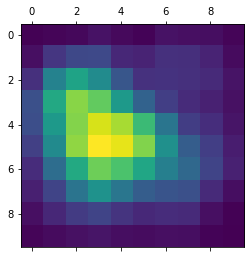

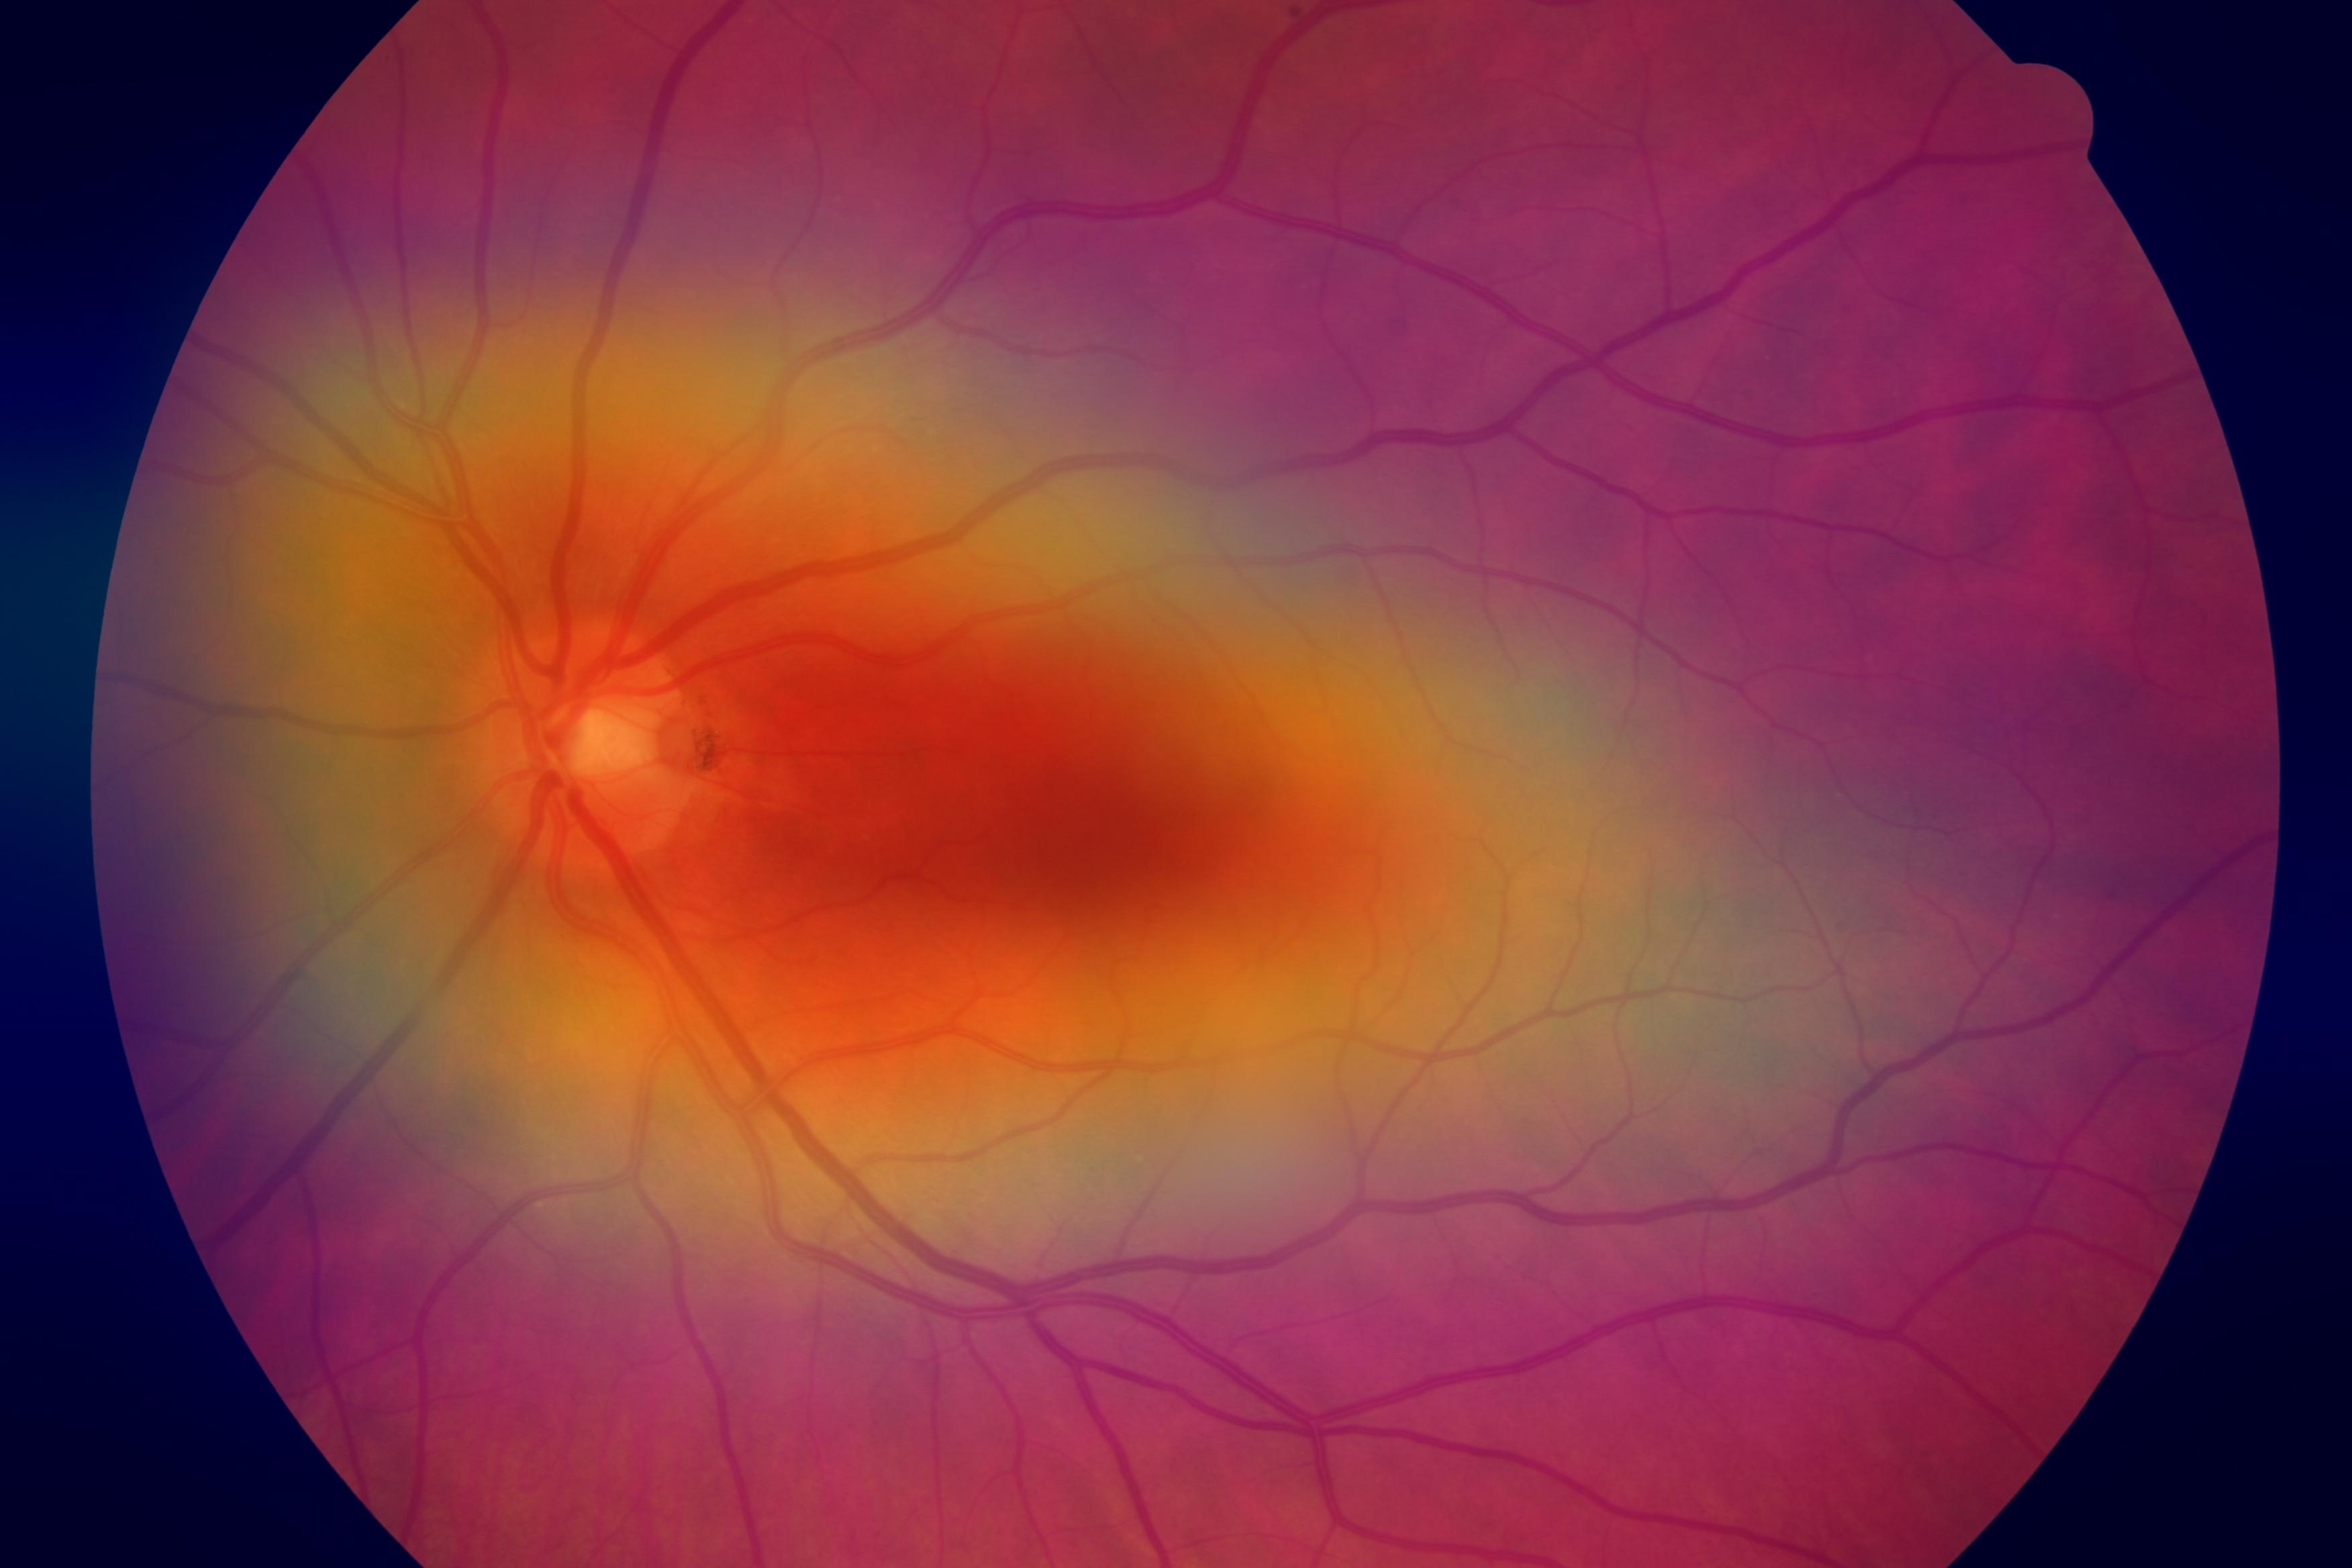

In [ ]:
# Generate heatmap

img_array = keras.applications.xception.preprocess_input(get_img_array(img_path, size=img_size))
#print(img_array.shape)
hmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(hmap)
plt.show()

#Display superimposed image
save_and_display_gradcam(img_path, hmap)